In [241]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cmasher as cmr # for color maps
from datetime import datetime, timedelta

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [242]:

with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']


In [243]:
# Output path
OUTPUT_PATH = postprocess['output_path']

# Input path
INPUT_PATH_S = postprocess['input_path_s']
INPUT_PATH_D = postprocess['input_path_d']

In [246]:
def calculate_end_date(start_date, period):
    """
    Berechnet das Enddatum basierend auf dem Startdatum und der Periode.

    Parameters:
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)

    Returns:
    - end_date: Enddatum im Format YYYYMMDD (int)
    """
    if isinstance(start_date, int):
        start_date = str(start_date)
    start_datetime = datetime.strptime(start_date, '%Y%m%d')
    
    if period == 0:  # Tag
        end_datetime = start_datetime
    elif period == 1:  # Woche
        end_datetime = start_datetime + timedelta(days=6)
    elif period == 2:  # Monat
        # Ende des Monats berechnen
        next_month = start_datetime.replace(day=28) + timedelta(days=4)  # garantiert im nächsten Monat
        end_datetime = next_month - timedelta(days=next_month.day)
    else:
        raise ValueError("Ungültige Periode. Wählen Sie 0: Tag, 1: Woche, 2: Monat.")
    
    return int(end_datetime.strftime('%Y%m%d'))


In [247]:
def load_deterministic_data(input_path, start_date, period_str, period):
    """
    Lädt die deterministischen Daten, behält den ursprünglichen 't'-Index bei und fügt eine 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den deterministischen CSV-Dateien
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period_str: Periode als String ('day', 'week', 'month')
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)
    
    Returns:
    - df: DataFrame mit ursprünglichem 't'-Index und 'timestamp'-Spalte
    """
    end_date = calculate_end_date(start_date, period)
    filename = f'd_{start_date}_to_{end_date}_{period_str}_ts.csv'
    file_path = os.path.join(input_path, filename)
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            return pd.DataFrame()
        
        # Berechnung des Startdatums
        start_datetime = datetime.strptime(str(start_date), '%Y%m%d')
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        # Überprüfen der Anzahl der Zeilen
        expected_rows = 24 if period == 0 else 168 if period == 1 else 720  # Für Monat kann angepasst werden
        if period == 2:
            # Für Monat die tatsächliche Anzahl der Tage * 24 berechnen
            end_datetime = datetime.strptime(str(end_date), '%Y%m%d')
            delta = end_datetime - start_datetime
            expected_rows = (delta.days + 1) * 24  # +1 für inklusive Enddatum
        if len(df) != expected_rows:
            print(f"Warnung: Die Anzahl der Zeilen in {filename} ({len(df)}) stimmt nicht mit der erwarteten Anzahl ({expected_rows}) überein.")
        
        return df
    else:
        print(f"Deterministische Datei {filename} nicht im Pfad {input_path} gefunden.")
        return pd.DataFrame()


In [248]:
def load_stochastic_data(input_path, start_date, period_str, period):
    """
    Lädt die stochastischen Daten, sortiert die Szenarien numerisch, behält den ursprünglichen 't'-Index bei und fügt eine einzige 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den stochastischen CSV-Dateien
    - start_date: Startdatum im Format YYYYMMDD (int oder str)
    - period_str: Periode als String ('day', 'week', 'month')
    - period: Periode als Integer (0: Tag, 1: Woche, 2: Monat)
    
    Returns:
    - combined_df: Kombinierter DataFrame mit ursprünglichem 't'-Index, einer 'timestamp'-Spalte und sortierten Szenarien
    """
    end_date = calculate_end_date(start_date, period)
    # Regex-Muster zum Extrahieren der Dateiinformationen
    pattern = re.compile(r's_(.*?)_' + str(start_date) + r'_to_' + str(end_date) + r'_' + re.escape(period_str) + r'_ts\.csv')
    stochastic_files = []

    # Durchsuchen des Verzeichnisses nach passenden Dateien
    for f in os.listdir(input_path):
        if f.startswith('s_') and f.endswith('_ts.csv'):
            match = pattern.match(f)
            if match:
                scenario = match.group(1)
                stochastic_files.append((f, scenario))

    if not stochastic_files:
        print("Keine passenden stochastischen Dateien gefunden.")
        return pd.DataFrame()

    # Sortieren der stochastic_files nach Szenariennummer
    def extract_scenario_number(scenario):
        # Extrahiert die erste gefundene Zahl aus dem Szenarionamen
        numbers = re.findall(r'\d+', scenario)
        return int(numbers[0]) if numbers else float('inf')

    stochastic_files_sorted = sorted(stochastic_files, key=lambda x: extract_scenario_number(x[1]))

    # Berechnung der erwarteten Anzahl der Stunden
    start_datetime = datetime.strptime(str(start_date), '%Y%m%d')
    end_datetime_obj = datetime.strptime(str(end_date), '%Y%m%d') + timedelta(hours=23)
    delta = end_datetime_obj - start_datetime
    total_hours = (delta.days + 1) * 24  # +1 für inklusive Enddatum

    # Initialisieren des kombinierten DataFrames und der 'timestamp'-Spalte
    combined_df = pd.DataFrame()
    timestamp_added = False  # Flag, um 'timestamp' nur einmal hinzuzufügen

    # Laden und Kombinieren der stochastischen Daten in der sortierten Reihenfolge
    for filename, scenario in stochastic_files_sorted:
        file_path = os.path.join(input_path, filename)
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            continue
        
        # Überprüfen der Anzahl der Zeilen
        if len(df) != total_hours:
            print(f"Die Anzahl der Zeilen in {filename} ({len(df)}) stimmt nicht mit der erwarteten Anzahl ({total_hours}) überein.")
            continue
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        if not timestamp_added:
            # Füge die 'timestamp'-Spalte nur einmal hinzu
            combined_df['timestamp'] = df['timestamp']
            timestamp_added = True
        else:
            # Entferne die 'timestamp'-Spalte für nachfolgende Szenarien
            df.drop(columns=['timestamp'], inplace=True)
        
        # Hinzufügen des Szenarionamens als Präfix zu den Spalten (außer 'timestamp')
        data_columns = df.columns.tolist()
        if 'timestamp' in data_columns:
            data_columns.remove('timestamp')
    
        
        # Kombinieren der Daten
        combined_df = pd.concat([combined_df, df], axis=1)
    
    return combined_df


In [249]:
# Create DataFrames
period_dict = {0: 'day', 1: 'week', 2: 'month'}

# Deterministic data Period: day
START_DATE = 20230614
PERIOD = 0
PERIOD_STR = period_dict[PERIOD]
df_deterministic_day = load_deterministic_data(INPUT_PATH_D, START_DATE, PERIOD_STR, PERIOD)

# Deterministic data Period: week
START_DATE = 20230327
PERIOD = 1
PERIOD_STR = period_dict[PERIOD]
df_deterministic_week = load_deterministic_data(INPUT_PATH_D, START_DATE, PERIOD_STR, PERIOD)


###################################################################################################

# Stochastic data Period: day
START_DATE = 20230614
PERIOD = 0
PERIOD_STR = period_dict[PERIOD]
df_stochastic_day = load_stochastic_data(INPUT_PATH_S, START_DATE, PERIOD_STR, PERIOD)

#Stochastic data Period: week
START_DATE = 20230327
PERIOD = 1
PERIOD_STR = period_dict[PERIOD]
df_stochastic_week = load_stochastic_data(INPUT_PATH_S, START_DATE, PERIOD_STR, PERIOD)

In [250]:
df_deterministic_day.head()
df_deterministic_week.head()
df_stochastic_day.head()
df_stochastic_week.head()

,timestamp,Scenario1.GAS_PRICE,Scenario1.POWER_PRICE,Scenario1.HEAT_PRICE,Scenario1.heat_demand,Scenario1.heat_demand_scenario,Scenario1.delta_heat_demand,Scenario1.probability,Scenario1.chp1.bin,Scenario1.chp1.power,...,Scenario10.heat_grid.dispatch_heat_supply,Scenario10.heat_grid.dispatch_heat_balance,Scenario10.arc01_expanded.power,Scenario10.arc02_expanded.power,Scenario10.arc03_expanded.heat,Scenario10.arc04_expanded.heat,Scenario10.arc05_expanded.heat,Scenario10.arc06_expanded.gas,Scenario10.arc07_expanded.gas,Scenario10.arc08_expanded.heat
t,,,,,,,,,,,,,,,,,,,,,
1,2023-03-27 00:00:00,0.1543,0.251,0.105,88.130612,75.398954,12.731658,0.01536,0.0,0.0,...,12.731658,0.0,0.0,0.0,0.0,0.0,174.0,162.464986,0.0,0.000000
2,2023-03-27 01:00:00,0.1543,0.251,0.105,106.310025,97.592323,8.717702,0.01536,0.0,0.0,...,8.717702,0.0,0.0,0.0,0.0,0.0,174.0,162.464986,0.0,0.000000
3,2023-03-27 02:00:00,0.1543,0.251,0.105,210.674806,249.302898,-38.628091,0.01536,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,174.0,162.464986,0.0,36.674806
4,2023-03-27 03:00:00,0.1543,0.251,0.105,146.480742,166.029479,-19.548737,0.01536,0.0,0.0,...,11.219356,0.0,0.0,0.0,0.0,0.0,174.0,162.464986,0.0,0.000000
5,2023-03-27 04:00:00,0.1543,0.251,0.105,158.708909,163.370873,-4.661963,0.01536,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,174.0,162.464986,0.0,0.000000


In [251]:
# Szenarien
scenarios = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

# Generate colors using cmasher colormap for scenarios
color_mapping = {}
num_scenarios = len(scenarios)
scenario_colors = cmr.take_cmap_colors('cmr.chroma', N=num_scenarios, cmap_range=(0.3, 0.9))

# Assign colors to scenarios (using cmasher)
for i, scenario in enumerate(scenarios):
    color_mapping[scenario] = scenario_colors[i]

# Fixed color for global parameters
color_mapping['HEAT_PRICE'] = 'red'
color_mapping['GAS_PRICE'] = 'orange'
color_mapping['POWER_PRICE'] = 'blue'




#### Heat Demand Scenarios (period: week)

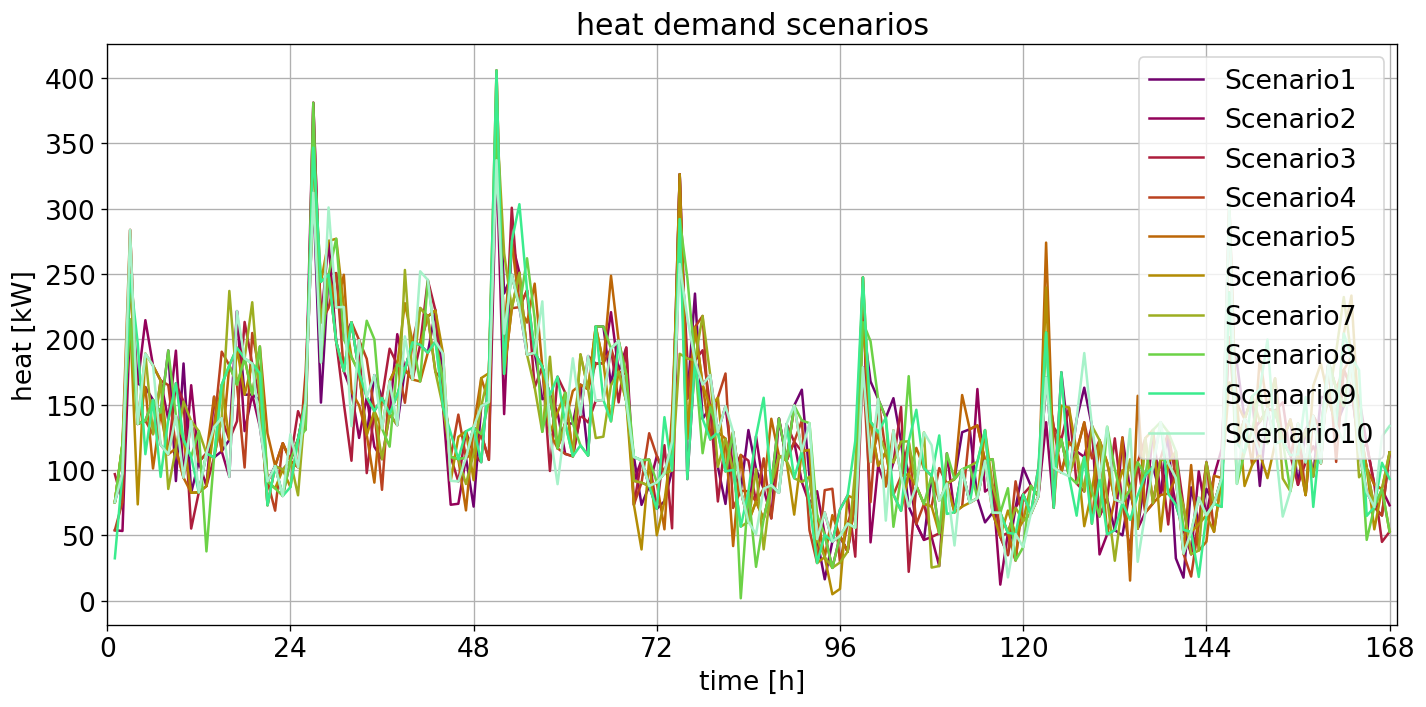

In [252]:
# Adjustable Parameters
params_to_plot = ['heat_demand_scenario']
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

data_to_plot = []
labels = []

for param in params_to_plot:
    for scenario in scenarios_to_plot:
        column_name = f'{scenario}.{param}'
        if column_name in df_stochastic_week.columns:
            data_to_plot.append(df_stochastic_week[column_name])
            labels.append(scenario)
        else:
            print(f"Spalte {column_name} existiert nicht in df_stochastic.")

# Get corresponding colors directly from the color mapping (fixed for each scenario)
plot_colors = [color_mapping[scenario] for scenario in scenarios_to_plot]

# Define font sizes
fontsize_title = 18
fontsize_label = 16
fontsize_ticks = 16

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Plot the scenarios
for i, data in enumerate(data_to_plot):
    ax.plot(df_stochastic_week.index, data, label=labels[i], color=plot_colors[i])

ax.set_title('heat demand scenarios', fontsize=fontsize_title)
ax.grid()
ax.set_ylabel("heat [kW]", fontsize=fontsize_label)
ax.set_xlabel("time [h]", fontsize=fontsize_label)
ax.legend(loc=1, fontsize=fontsize_ticks)
ax.set_xticks(range(0, len(df_stochastic_week)+1, 24))
ax.set_xticklabels(range(0, len(df_stochastic_week)+1, 24), fontsize=fontsize_label)
ax.set_xlim([0, len(df_stochastic_week)+1])
ax.tick_params(axis='both', labelsize=fontsize_ticks)

plt.tight_layout()


#### Heat Demand Scenarios (period: day)

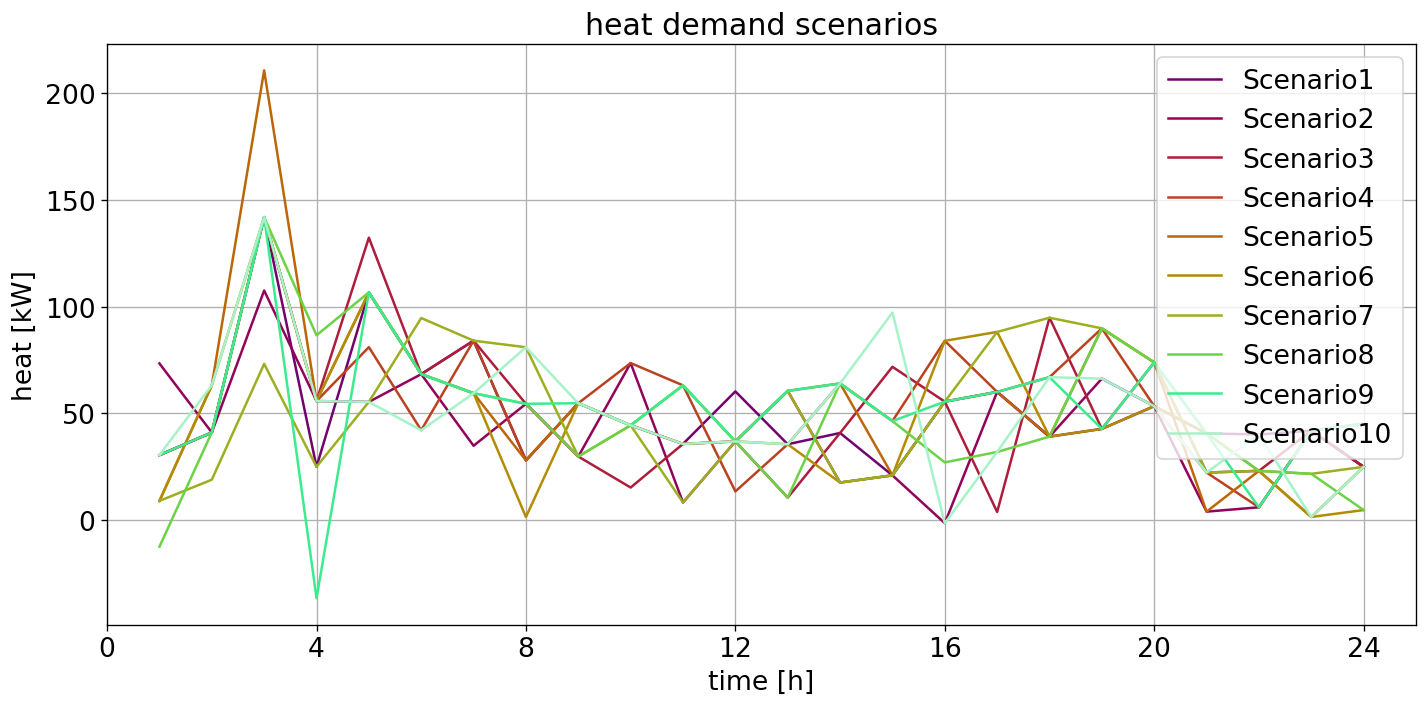

In [253]:
# Adjustable Parameters
params_to_plot = ['heat_demand_scenario']
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']

data_to_plot = []
labels = []

for param in params_to_plot:
    for scenario in scenarios_to_plot:
        column_name = f'{scenario}.{param}'
        if column_name in df_stochastic_day.columns:
            data_to_plot.append(df_stochastic_day[column_name])
            labels.append(scenario)
        else:
            print(f"Spalte {column_name} existiert nicht in df_stochastic.")

# Get corresponding colors directly from the color mapping (fixed for each scenario)
plot_colors = [color_mapping[scenario] for scenario in scenarios_to_plot]

# Define font sizes
fontsize_title = 18
fontsize_label = 16
fontsize_ticks = 16

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Plot the scenarios
for i, data in enumerate(data_to_plot):
    ax.plot(df_stochastic_day.index, data, label=labels[i], color=plot_colors[i])

ax.set_title('heat demand scenarios', fontsize=fontsize_title)
ax.grid()
ax.set_ylabel("heat [kW]", fontsize=fontsize_label)
ax.set_xlabel("time [h]", fontsize=fontsize_label)
ax.legend(loc=1, fontsize=fontsize_ticks)
ax.set_xticks(range(0, len(df_stochastic_day)+1, 4))
ax.set_xticklabels(range(0, len(df_stochastic_day)+1, 4), fontsize=fontsize_label)
ax.set_xlim([0, len(df_stochastic_day)+1])
ax.tick_params(axis='both', labelsize=fontsize_ticks)

plt.tight_layout()


 #### Options for the place of the plot legend
 
    # 'best'         : 0,
    # 'upper right'  : 1,
    # 'upper left'   : 2,
    # 'lower left'   : 3,
    # 'lower right'  : 4,
    # 'right'        : 5,
    # 'center left'  : 6,
    # 'center right' : 7,
    # 'lower center' : 8,
    # 'upper center' : 9,
    # 'center'       : 10

#### Deterministic Model: Heat Distribution

[-41.96746255 -35.39631034   0.          67.01630691  -8.84572265
 -51.92737014  71.12055877 -21.74189131 -26.16721038 -30.90592426
  52.66884135 -36.49008825 -38.91041445 -33.31838517 -24.53939761
  67.82369885 -17.86881562 -13.88379284  63.16704883 -26.04365335
  42.52147957  42.43408019 -42.37842525  43.63284969]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 85.2         85.2        103.23696639   0.          85.2
 123.46360186   0.          85.2         85.2         85.2
   0.          85.2         88.90976028  85.2         85.2
   0.          85.2         85.2          0.          85.2
   0.           0.          85.2          0.        ]


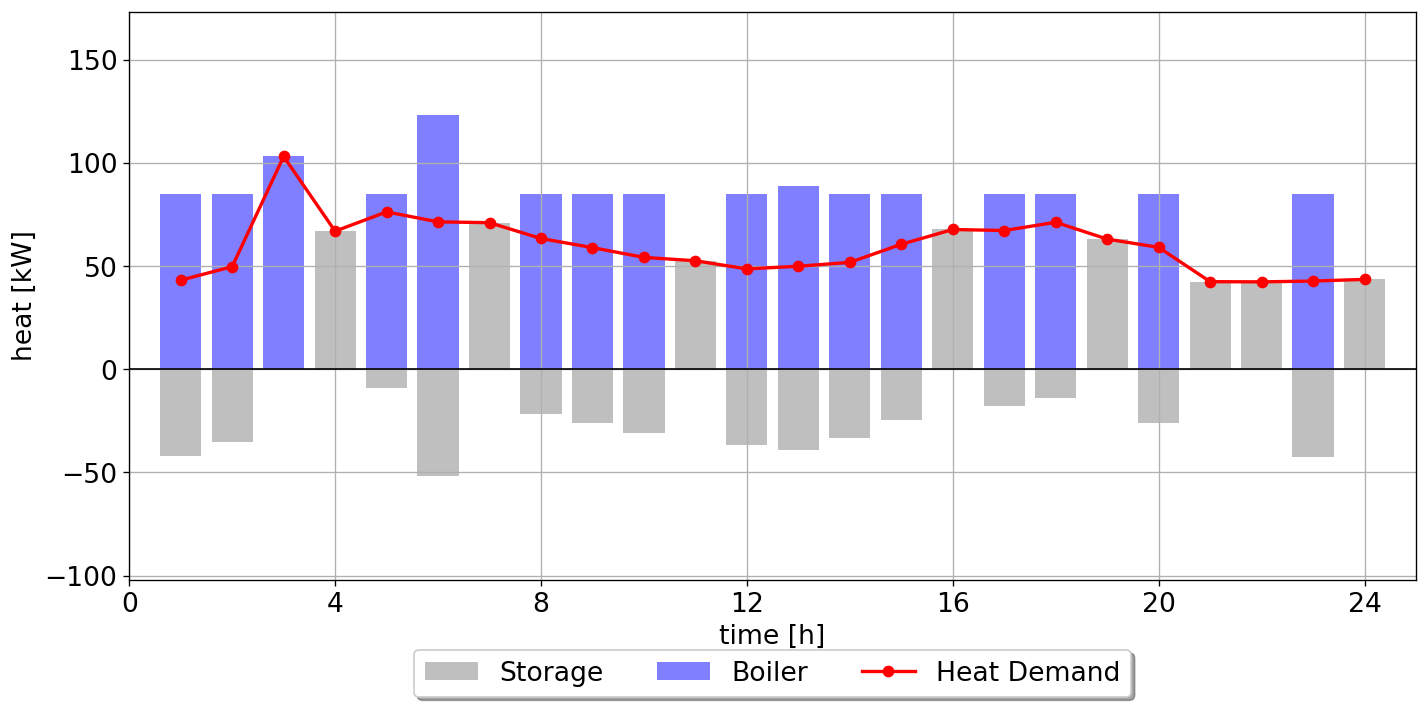

In [254]:
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr


# Use the index of the DataFrame as time (hours)
hours = df_deterministic_day.index

# Extract the data
chp1 = df_deterministic_day['chp1.heat']
chp2 = df_deterministic_day['chp2.heat']
boiler = df_deterministic_day['boiler1.heat']
storage_in = -df_deterministic_day['heat_storage1.heat_charge']  # Negative for charging operations
storage_out = df_deterministic_day['heat_storage1.heat_discharge']  # Positive for discharging
storage = storage_in + storage_out  # Net storage flow
hd = df_deterministic_day['heat_demand']  # Heat demand (line plot)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Initialize cumulative sums for stacking
pos_bottom = np.zeros(len(hours))
neg_bottom = np.zeros(len(hours))

# Components to plot
components = [
    (storage, 'Storage', 'grey'),
    (chp1, 'CHP_1', 'green'),
    (chp2, 'CHP_2', 'darkrgeen'),
    (boiler, 'Boiler', 'blue'),
]

# To avoid duplicate labels in the legend
handles = []
labels = []

# Plot each component
for data_component, label, color in components:
    data_component = np.array(data_component)
    print(data_component)
    # Separate positive and negative values
    pos_values = np.where(data_component > 0, data_component, 0)
    neg_values = np.where(data_component < 0, data_component, 0)
    # Plot positive values
    if np.any(pos_values):
        bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
        pos_bottom += pos_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)
    # Plot negative values
    if np.any(neg_values):
        bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
        neg_bottom += neg_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)

# Plot the line for Heat Demand
line_hd, = ax.plot(hours, hd, label='Heat Demand', color='red', marker='o', linewidth=2)
handles.append(line_hd)
labels.append('Heat Demand')

# Add horizontal line at y=0
ax.axhline(0, color='black', linewidth=1)

# Set axis labels and title
# Set Axis Properties


# Adjust the grid, ticks, and axis limits
ax.grid(True)
ax.set_xticks(np.arange(0, 25, 4))  # X-axis with hours
ax.set_xlim([0, 25])  # Set the X range
ax.set_ylim([neg_bottom.min() - 50, pos_bottom.max() + 50])  # Adjust Y range based on data
ax.tick_params(axis='both', labelsize=fontsize_ticks)
ax.set_ylabel("heat [kW]", fontsize=fontsize_label)
ax.set_xlabel("time [h]", fontsize=fontsize_label)

# Add the legend
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize=fontsize_ticks)

# Show the plot
plt.tight_layout()
plt.show() 

[ -85.86938793  -67.68997501   36.67480636    0.            0.
  -17.18201151    0.            0.            0.            0.
    0.            0.            0.          -30.07774691  -20.03050012
   12.48235674    0.           15.77093597    4.15899549  -14.71583467
    0.          -51.65121158    0.          -48.21594247    0.
  -12.20681542  133.94553213   50.33809214    2.92845964   53.51863998
   37.82160716  -46.50297819  -63.32102181   -8.24820217  -11.86970244
  -30.50171135  -74.72390469   -5.43841729   17.07402439   35.97825889
   29.11531531   47.85009049   21.40575877    0.19685672  -43.75028107
  -46.38382796  -30.84825064  -42.89291685  -33.85199333  -13.28709675
   42.68121765    0.           70.69765473   53.719359     50.44329904
  -33.41723247    9.36446681   -6.62251404    0.            0.
  -24.06286028  -20.89490308    2.05095759   19.646473     14.9600828
   23.25429764   -1.8745046     0.          -62.10009371    0.
    0.            0.            0.            0

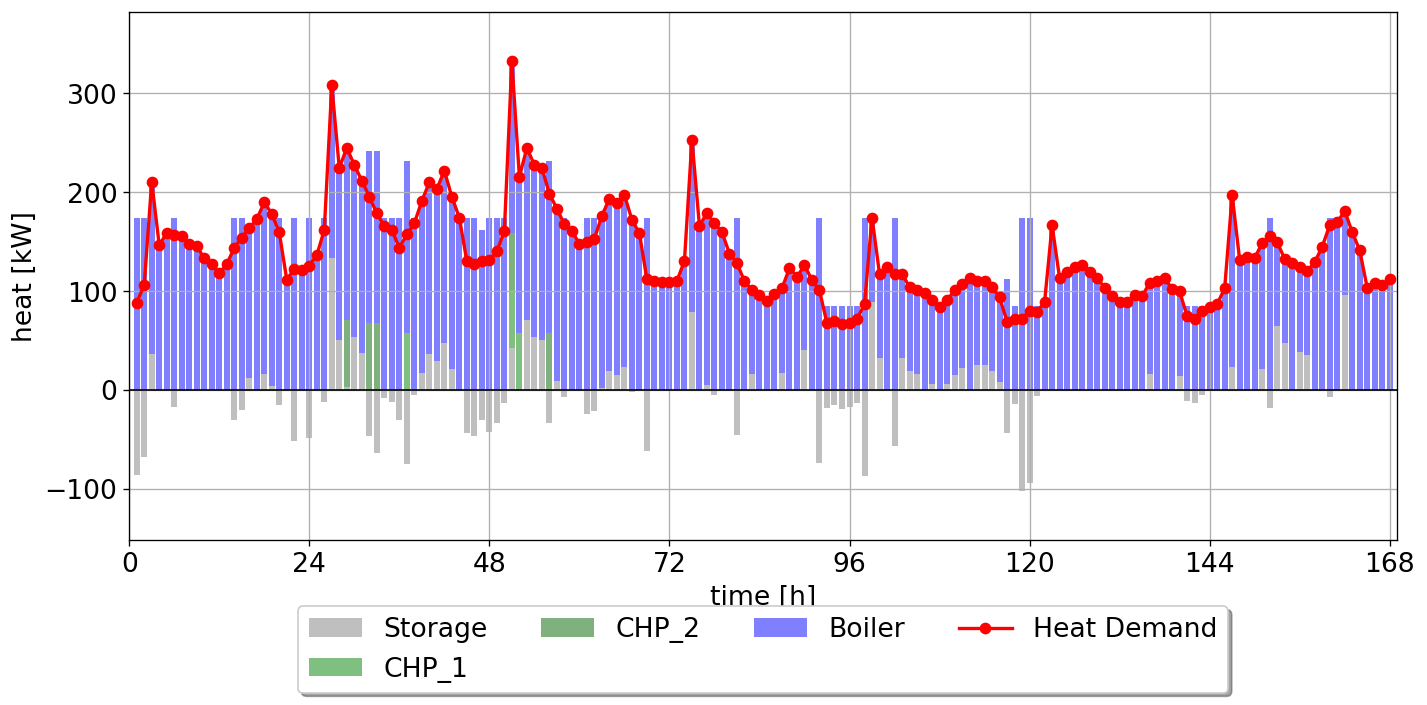

In [255]:
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr


# Use the index of the DataFrame as time (hours)
hours = df_deterministic_week.index

# Extract the data
chp1 = df_deterministic_week['chp1.heat']
chp2 = df_deterministic_week['chp2.heat']
boiler = df_deterministic_week['boiler1.heat']
storage_in = -df_deterministic_week['heat_storage1.heat_charge']  # Negative for charging operations
storage_out = df_deterministic_week['heat_storage1.heat_discharge']  # Positive for discharging
storage = storage_in + storage_out  # Net storage flow
hd = df_deterministic_week['heat_demand']  # Heat demand (line plot)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Initialize cumulative sums for stacking
pos_bottom = np.zeros(len(hours))
neg_bottom = np.zeros(len(hours))

# Components to plot
components = [
    (storage, 'Storage', 'grey'),
    (chp1, 'CHP_1', 'green'),
    (chp2, 'CHP_2', 'darkgreen'),
    (boiler, 'Boiler', 'blue'),
]

# To avoid duplicate labels in the legend
handles = []
labels = []

# Plot each component
for data_component, label, color in components:
    data_component = np.array(data_component)
    print(data_component)
    # Separate positive and negative values
    pos_values = np.where(data_component > 0, data_component, 0)
    neg_values = np.where(data_component < 0, data_component, 0)
    # Plot positive values
    if np.any(pos_values):
        bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
        pos_bottom += pos_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)
    # Plot negative values
    if np.any(neg_values):
        bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
        neg_bottom += neg_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)

# Plot the line for Heat Demand
line_hd, = ax.plot(hours, hd, label='Heat Demand', color='red', marker='o', linewidth=2)
handles.append(line_hd)
labels.append('Heat Demand')

# Add horizontal line at y=0
ax.axhline(0, color='black', linewidth=1)

# Set axis labels and title
# Set Axis Properties


# Adjust the grid, ticks, and axis limits
ax.grid(True)
ax.set_xticks(np.arange(0, len(df_deterministic_week)+1, 24))  # X-axis with hours
ax.set_xlim([0, len(df_deterministic_week) +1])  # Set the X range
ax.set_ylim([neg_bottom.min() - 50, pos_bottom.max() + 50])  # Adjust Y range based on data
ax.tick_params(axis='both', labelsize=fontsize_ticks)
ax.set_ylabel("heat [kW]", fontsize=fontsize_label)
ax.set_xlabel("time [h]", fontsize=fontsize_label)

# Add the legend
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize=fontsize_ticks)

# Show the plot
plt.tight_layout()
plt.show() 

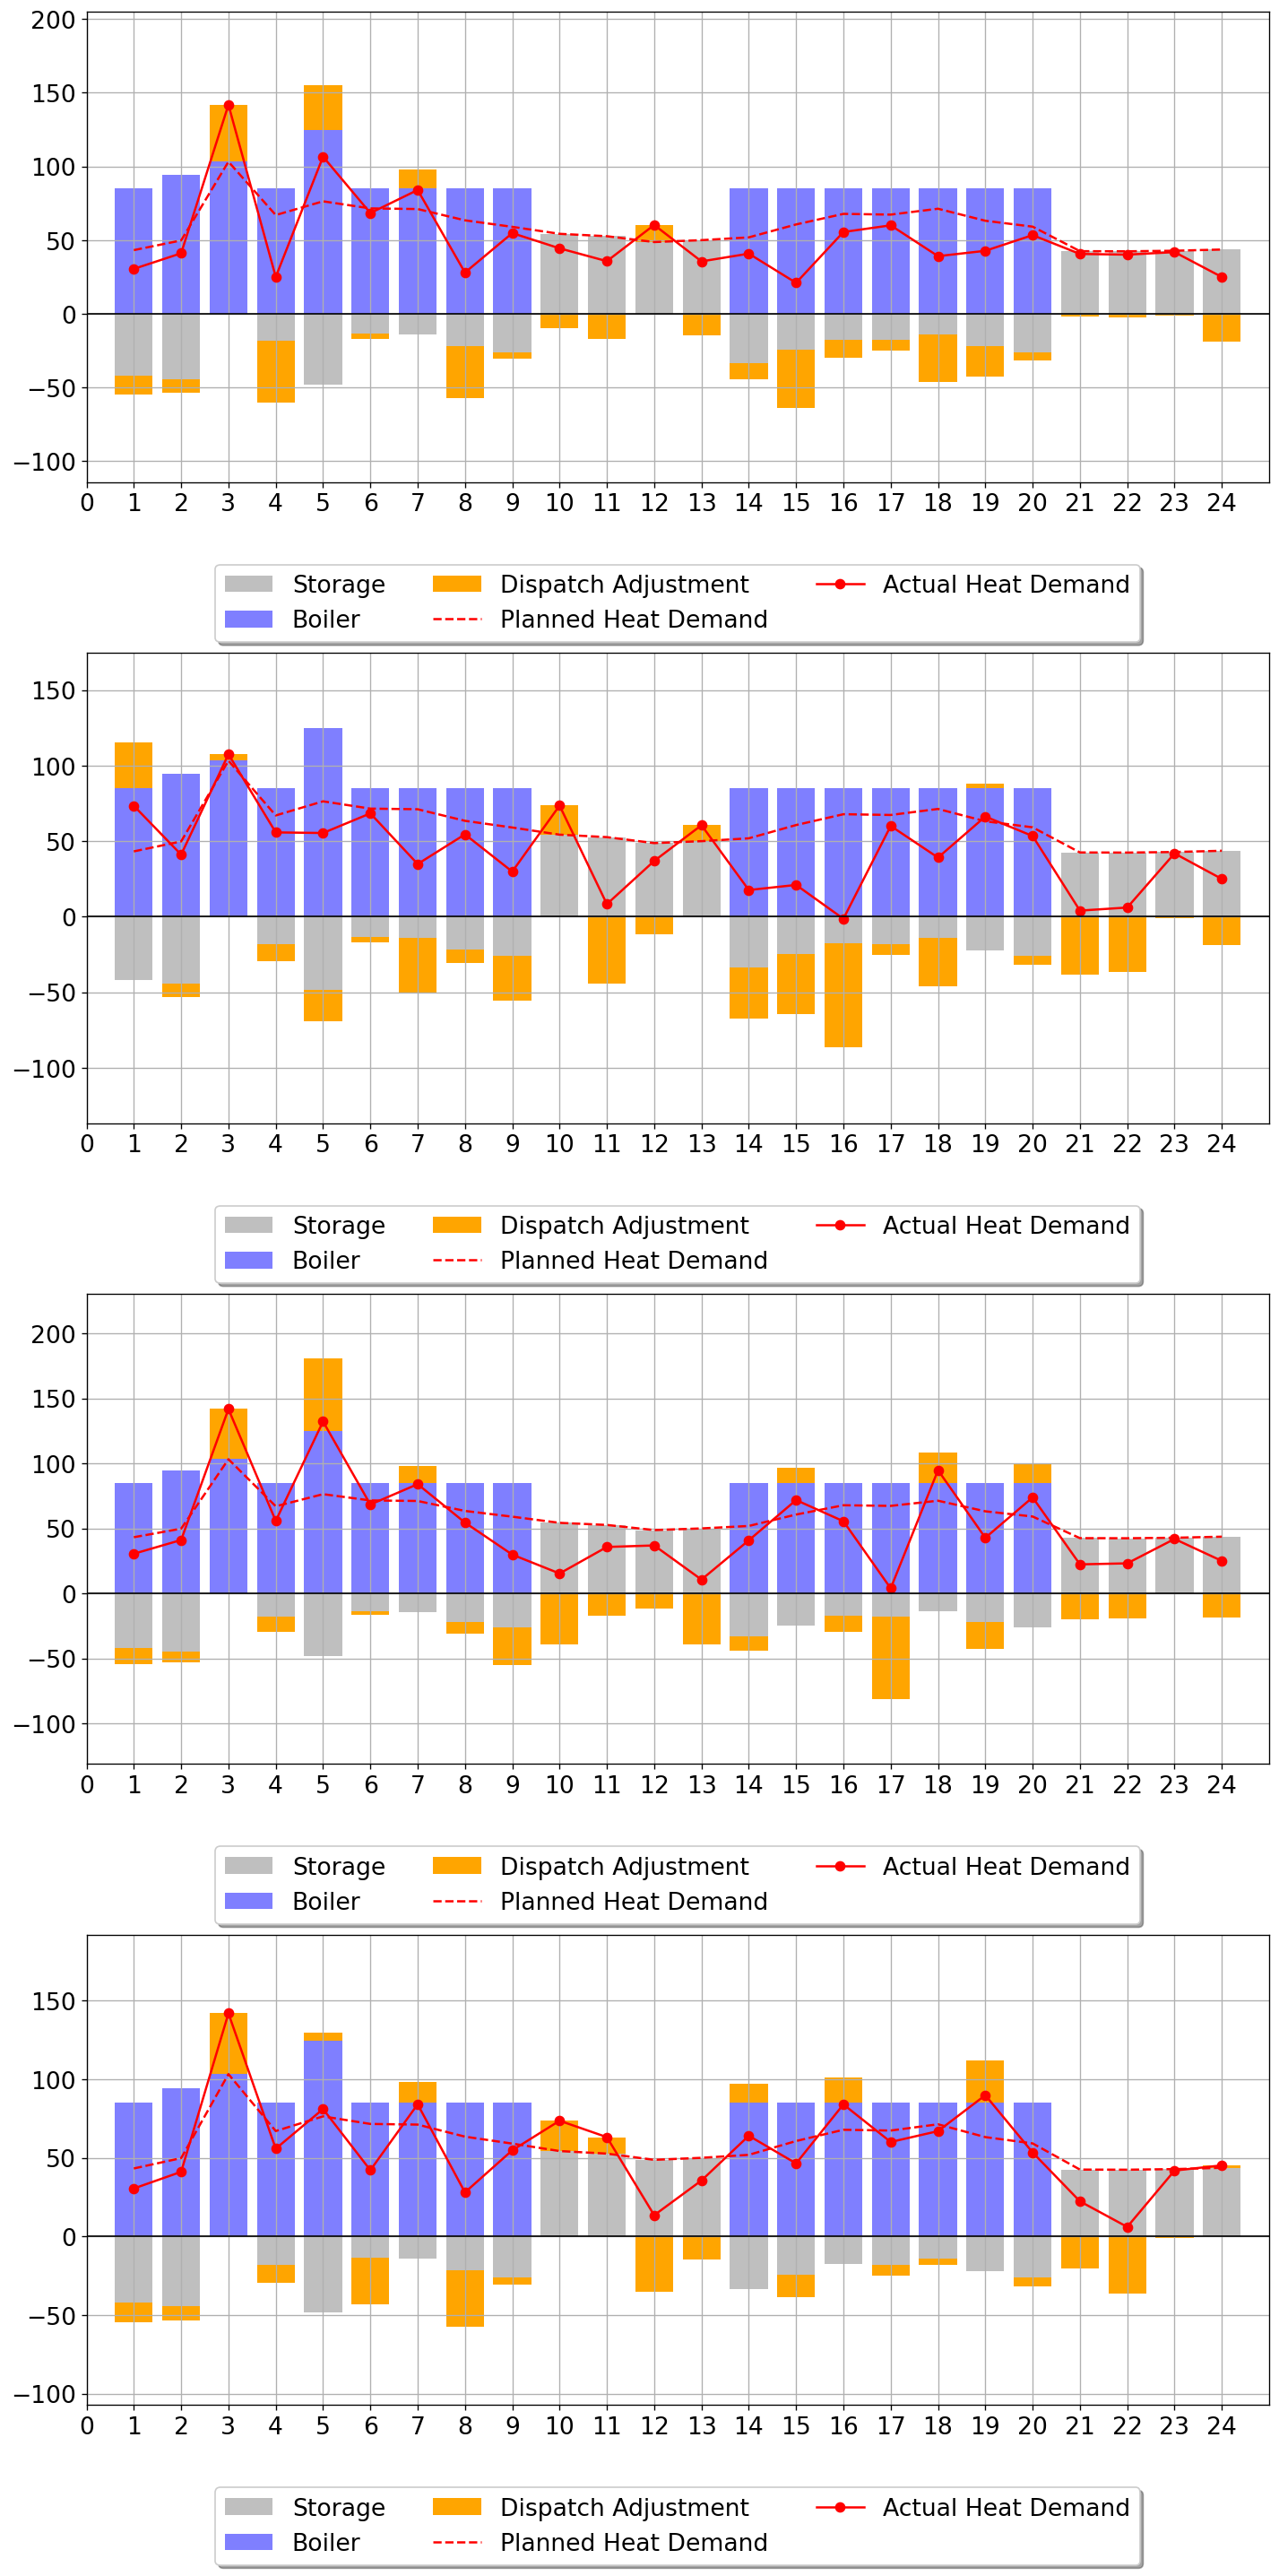

In [257]:
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr

# Use the index of the DataFrame as time (hours)
hours = df_stochastic_day.index

# Extract the first-stage data (common across scenarios)
chp1 = df_stochastic_day['Scenario1.chp1.heat']
chp2 = df_stochastic_day['Scenario1.chp2.heat']
boiler = df_stochastic_day['Scenario1.boiler1.heat']
storage_in = -df_stochastic_day['Scenario1.heat_storage1.heat_charge']  # Negative for charging operations
storage_out = df_stochastic_day['Scenario1.heat_storage1.heat_discharge']  # Positive for discharging
storage = storage_in + storage_out  # Net storage flow
planned_hd = df_stochastic_day['Scenario1.heat_demand']  # Planned heat demand

# Components for first-stage plot
first_stage_components = [
    (storage, 'Storage', 'grey'),
    (chp1, 'CHP_1', 'green'),
    (chp2, 'CHP_2', 'darkrgeen'),
    (boiler, 'Boiler', 'blue'),
]

# Number of scenarios
scenarios = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4']  # Add more scenarios as needed

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(12, 6 * len(scenarios)), dpi=120)

# If there's only one scenario, axes might not be an array
if len(scenarios) == 1:
    axes = [axes]

for ax, scenario in zip(axes, scenarios):
    # Extract second-stage data for the scenario
    dispatch_charge = -df_stochastic_day[f'{scenario}.heat_storage1.dispatch_heat_charge']  # Negative for charging
    dispatch_discharge = df_stochastic_day[f'{scenario}.heat_storage1.dispatch_heat_discharge']  # Positive for discharging
    actual_hd = df_stochastic_day[f'{scenario}.heat_demand_scenario']  # Actual heat demand for the scenario

    # Initialize cumulative sums for stacking
    pos_bottom = np.zeros(len(hours))
    neg_bottom = np.zeros(len(hours))

    # Plot first-stage components
    handles = []
    labels = []
    for data_component, label, color in first_stage_components:
        data_component = np.array(data_component)
        # Separate positive and negative values
        pos_values = np.where(data_component > 0, data_component, 0)
        neg_values = np.where(data_component < 0, data_component, 0)
        # Plot positive values
        if np.any(pos_values):
            bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
            pos_bottom += pos_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)
        # Plot negative values
        if np.any(neg_values):
            bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
            neg_bottom += neg_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)

    # Plot second-stage adjustments (dispatch)
    # We'll plot the adjustments as an overlay on top of the first-stage storage component
    dispatch_total = dispatch_charge + dispatch_discharge
    # Separate positive and negative adjustments
    dispatch_pos = np.where(dispatch_total > 0, dispatch_total, 0)
    dispatch_neg = np.where(dispatch_total < 0, dispatch_total, 0)
    # Plot positive adjustments
    if np.any(dispatch_pos):
        bars = ax.bar(hours, dispatch_pos, bottom=pos_bottom, color='orange', label='Dispatch Adjustment')
        pos_bottom += dispatch_pos
        if 'Dispatch Adjustment' not in labels:
            handles.append(bars[0])
            labels.append('Dispatch Adjustment')
    # Plot negative adjustments
    if np.any(dispatch_neg):
        bars = ax.bar(hours, dispatch_neg, bottom=neg_bottom, color='orange')
        neg_bottom += dispatch_neg

    # Plot planned and actual heat demand
    line_planned, = ax.plot(hours, planned_hd, label='Planned Heat Demand', color='red', linestyle='--')
    line_actual, = ax.plot(hours, actual_hd, label='Actual Heat Demand', color='red', marker='o')
    handles.extend([line_planned, line_actual])
    labels.extend(['Planned Heat Demand', 'Actual Heat Demand'])

    # Add horizontal line at y=0
    ax.axhline(0, color='black', linewidth=1)

    # Set axis labels and title


    # Adjust the grid, ticks, and axis limits
    ax.grid(True)
    ax.set_xticks(np.arange(0, 25, 1))  # X-axis with hours
    ax.set_xlim([0, 25])  # Set the X range
    y_min = min(neg_bottom.min(), dispatch_neg.min(), -50)
    y_max = max(pos_bottom.max(), dispatch_pos.max(), 50)
    ax.set_ylim([y_min - 50, y_max + 50])  # Adjust Y range based on data
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Add the legend
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3, fontsize=fontsize_ticks)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


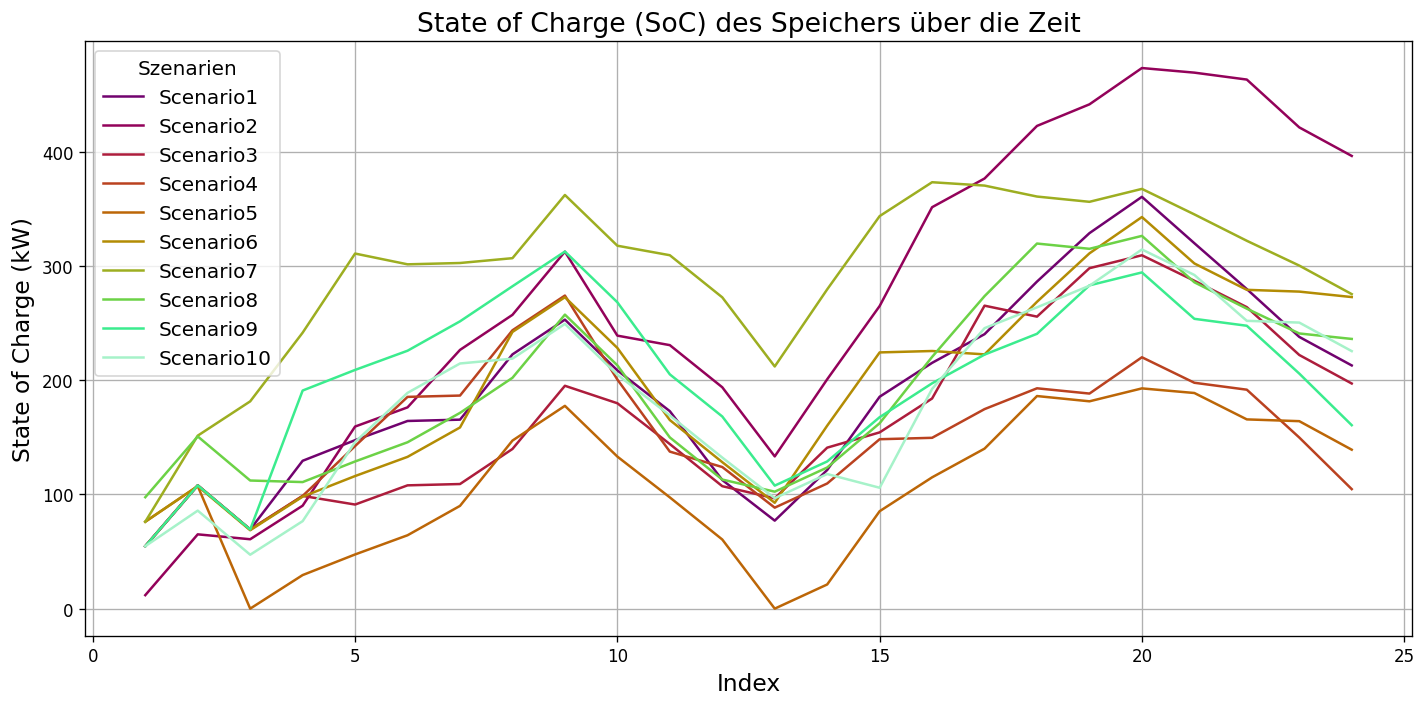

In [265]:
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5', 'Scenario6', 'Scenario7', 'Scenario8', 'Scenario9', 'Scenario10']
# Liste zur Speicherung der SoC-Daten für alle Szenarien
soc_data = {}

# Iteriere über jedes Szenario und berechne den SoC
for scenario in scenarios_to_plot:
    # Definiere die relevanten Spalten
    charge_col = f'{scenario}.heat_storage1.heat_charge'
    charge_col_dispatch = f'{scenario}.heat_storage1.dispatch_heat_charge'
    discharge_col = f'{scenario}.heat_storage1.heat_discharge'
    discharge_col_dispatch = f'{scenario}.heat_storage1.dispatch_heat_discharge'
    capacity_col = f'{scenario}.heat_storage1.heat_capacity'
    capacity_col_dispatch = f'{scenario}.heat_storage1.dispatch_heat_capacity'
    
    # Extrahiere die Daten
    charge = df_stochastic_day[charge_col]
    discharge = df_stochastic_day[discharge_col]
    
    dispatch_charge = df_stochastic_day[charge_col_dispatch]
    dispatch_discharge = df_stochastic_day[discharge_col_dispatch]

    # Berechne den Netto-Heat-Flow
    net_heat_flow = charge + dispatch_charge - discharge - dispatch_discharge
    
    # Kumulative Summe zur Berechnung des SoC
    soc = net_heat_flow.cumsum()
    
    soc_data[scenario] = soc

# Define font sizes
fontsize_title = 16
fontsize_label = 14

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Plot den SoC für jedes Szenario
for scenario in scenarios_to_plot:
    if scenario in soc_data:
        ax.plot(soc_data[scenario].index, soc_data[scenario], label=scenario, color=color_mapping[scenario])

# Setze die Achsen-Eigenschaften und Titel
ax.set_title('State of Charge (SoC) des Speichers über die Zeit', fontsize=fontsize_title)
ax.set_xlabel('Index', fontsize=fontsize_label)
ax.set_ylabel('State of Charge (kW)', fontsize=fontsize_label)
ax.legend(title='Szenarien', fontsize=12, title_fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()

